In [1]:
import warnings
notebook_warnings = []
def warning_collector(message, category, filename, lineno, file=None, line=None):
    notebook_warnings.append(f"{category.__name__}: {message} (File {filename}, line {lineno})")
warnings.showwarning = warning_collector


In [2]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by:    Margaret Duff (STFC-UKRI)
#                  Vaggelis Papoutsellis (Finden)
#                  Jakob Sauer Jørgensen (DTU)
#                  Laura Murgatroyd (STFC- UKRI)

In [3]:
import cil
from cil.optimisation.functions import L2NormSquared, TotalVariation, MixedL21Norm
from cil.optimisation.operators import BlockOperator, FiniteDifferenceOperator, CompositionOperator, DiagonalOperator
from cil.optimisation.algorithms import PDHG
from cil.utilities import dataexample
from cil.plugins.ccpi_regularisation.functions import FGP_dTV
import numpy as np

from cil.utilities import dataexample
from cil.utilities.display import show2D
from cil.recon import FDK
from cil.processors import TransmissionAbsorptionConverter, Slicer

import numpy as np

from cil.plugins.tigre import ProjectionOperator
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import LeastSquares, TotalVariation
from cil.optimisation.operators import BlurringOperator

import matplotlib.pyplot as plt

# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'

print(cil.__version__)

25.0.0



# Simulated sphere fan beam reconstruction using directional total variation 

In this notebook we motivate and demonstrate the directional TV regulariser from the CCPi regularisation toolkit. We use this regulariser to reconstruct a slice from a simulated sphere cone beam dataset where the forward model involves a gaussian blur and then a tomographic cone beam projection. We then show how this regulariser could be implemented using the CIL optimisation toolkit. 

Learning objectives:
- Introduce the dTV regulariser 
- Demonstrate the dTV regularisation using the CCPi regularisation toolkit, seeing examples of over and under regularisation 
- Use the CIL BlockFramework and PDHG to define and minimise an objective function written in CIL for using dTV for denoising.

For further examples of using dTV and for references, please see the [second CIL paper](https://doi.org/10.1098/rsta.2020.0193) and the accompanying [code](https://github.com/TomographicImaging/Paper-2021-RSTA-CIL-Part-II/tree/main/CaseStudy_DynamicTomography) as well as the [3_Multichannel/02_Dynamic_CT.ipynb](https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/3_Multichannel/02_Dynamic_CT.ipynb) notebook from CIL Demos.

## Load, create and show the data

We use the simulated spheres dataset contained in the CIL `dataexample` module. We consider just the central slice for this notebook. 

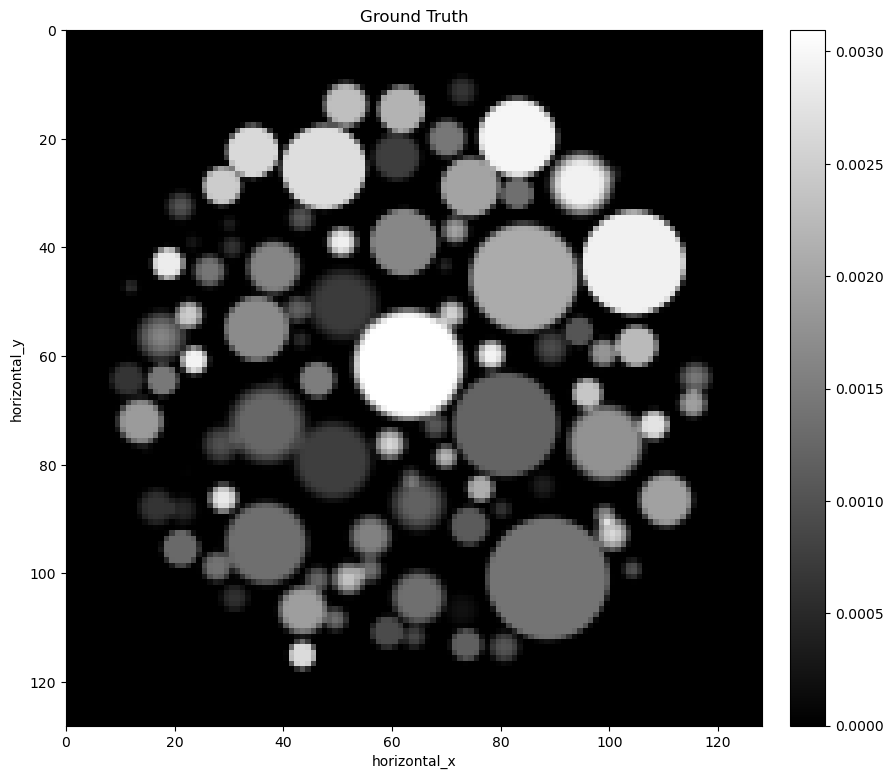

In [4]:
# %% Load data
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()

data = data.get_slice(vertical='centre')
ag = data.geometry
absorption = TransmissionAbsorptionConverter()(data)

ground_truth = ground_truth.get_slice(vertical='centre')
ig = ground_truth.geometry

show2D([ground_truth], title=['Ground Truth'], origin='upper', num_cols=1);

For the forward model, we will include both a tomographic projection and a blur. In the next cell, we define a point spread function and pass this to the CIL `BlurringOperator`.

In [5]:
def psf(n=5, sig=1.):
    """
    creates psf with side length `n` and a sigma of `sig`
    """
    ax = np.linspace(-(n - 1) / 2., (n - 1) / 2., n)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)


PSF = psf(5, 2)
B = BlurringOperator(PSF, ig)

Applying this to the ground truth image, we can see the effect of the blurring operator: 

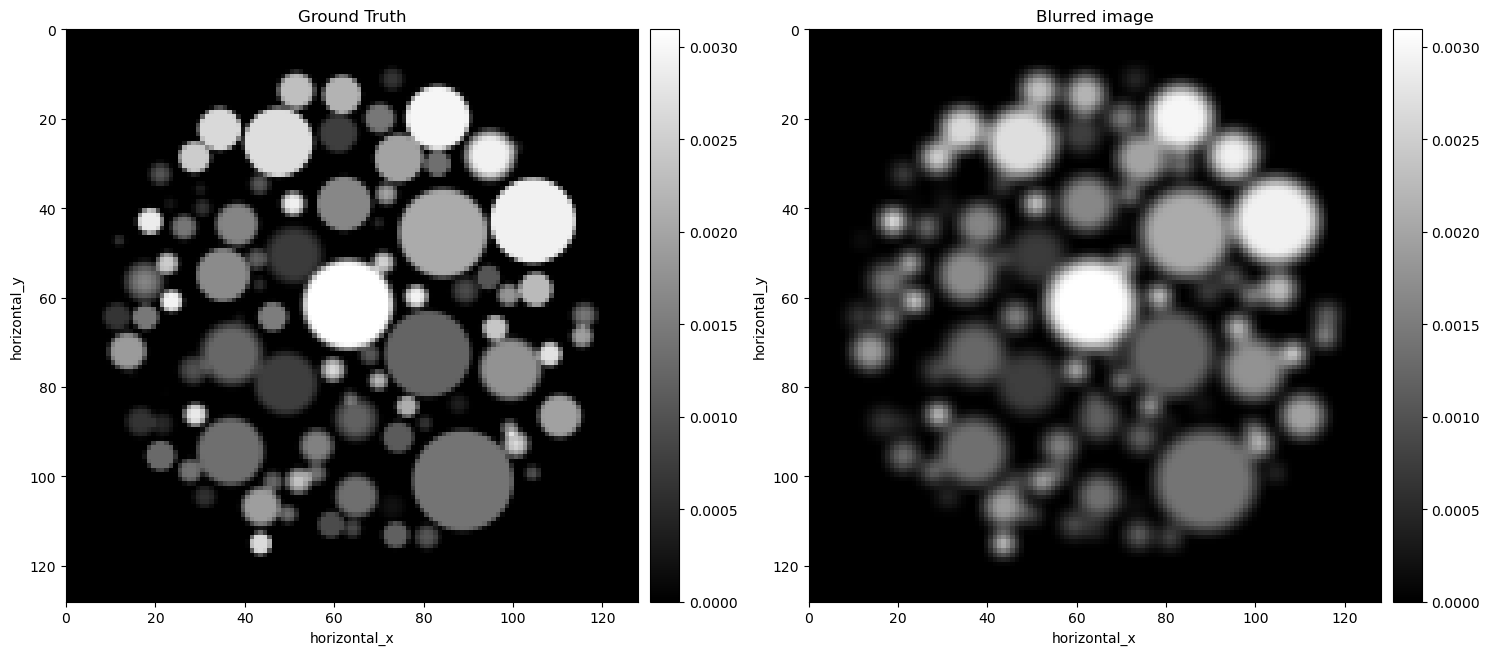

In [6]:
show2D([ground_truth, B.direct(ground_truth)], title=['Ground Truth',
       'Blurred image'], origin='upper', num_cols=2);

We now define the tomographic projection operator. 

In [7]:
A = ProjectionOperator(image_geometry=ig,
                       acquisition_geometry=ag)

We now compose the two operators and apply it to our ground truth data before adding noise. We compare the original sinogram with the new noisy and blurred sinogram. 

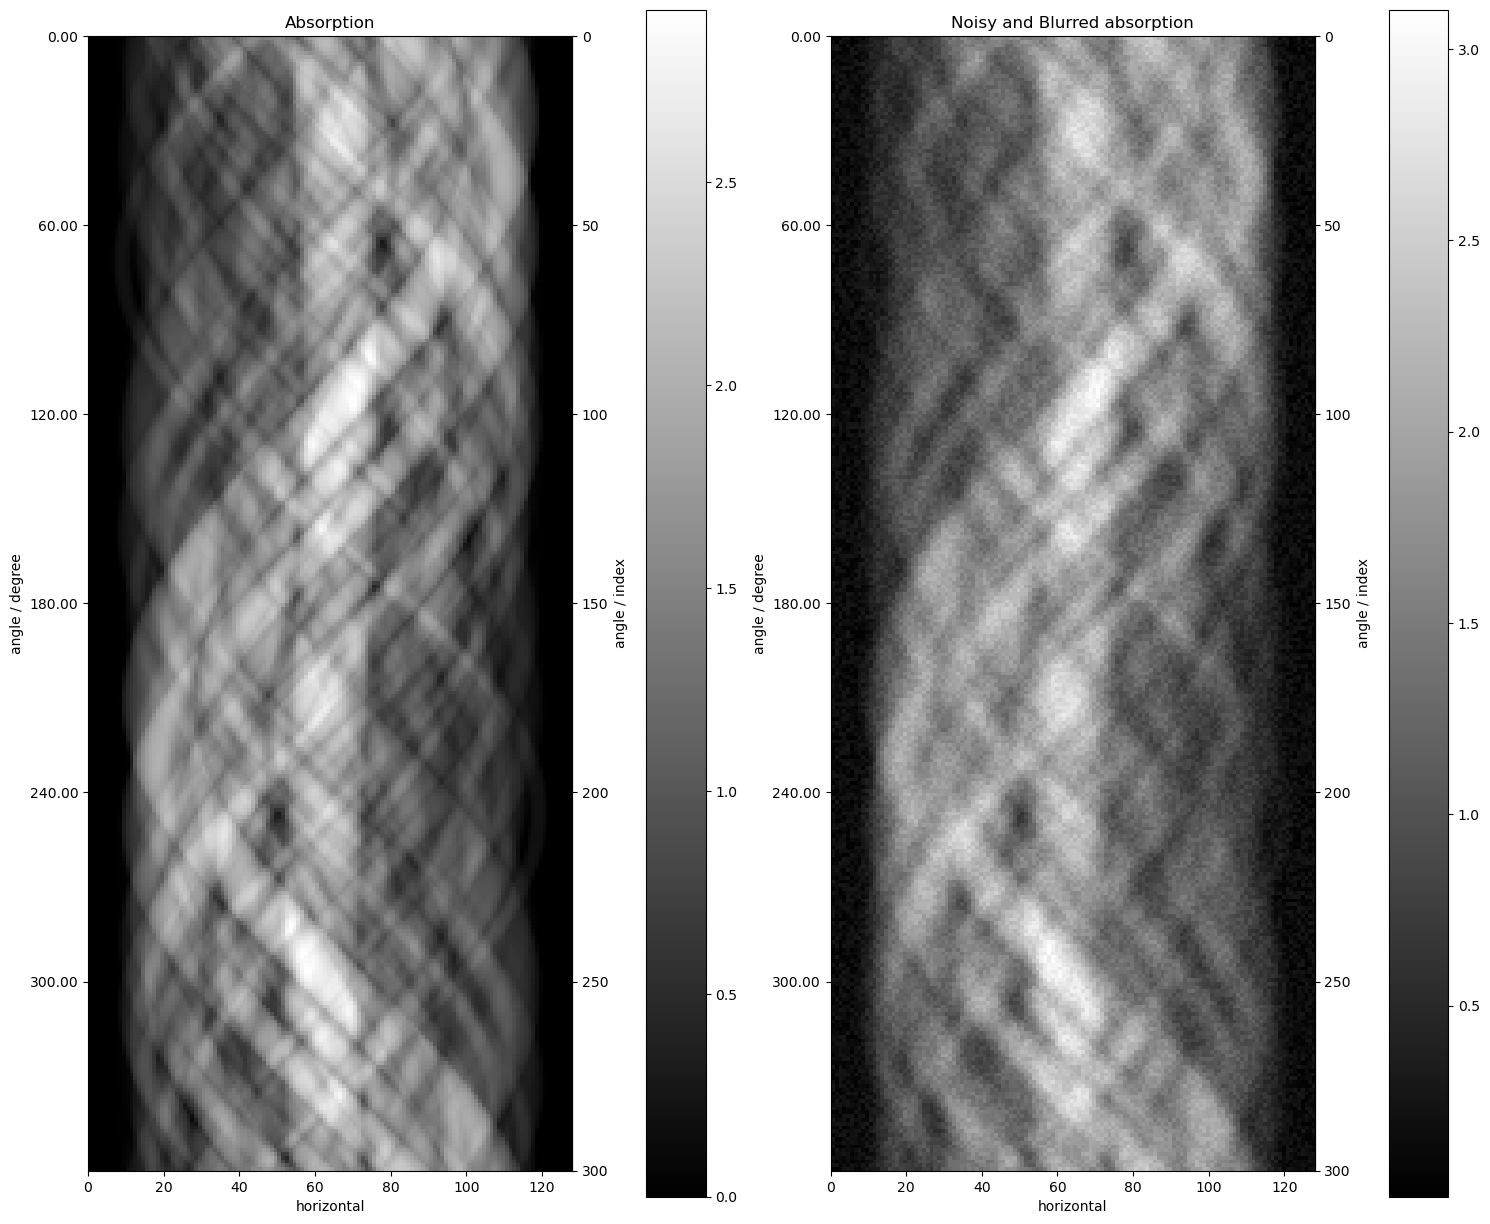

In [8]:

forward = CompositionOperator(A, B)

noisy_absorption = forward.direct(ground_truth)
noisy_absorption += 0.1*noisy_absorption.array.max() * \
    noisy_absorption.geometry.allocate('random')

show2D([absorption, noisy_absorption], title=[
       'Absorption', 'Noisy and Blurred absorption'], origin='upper', num_cols=2);

We can use FDK to attempt to reconstruct the data. The FDK reconstruction assumes the data arises only from a tomographic acquisition and knows nothing about the noise or the blurring.  As expected, it is both blurred and noisy compared to the ground truth image. In the next few sections, we will try and improve this reconstruction.


FDK recon

Input Data:
	angle: 300
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



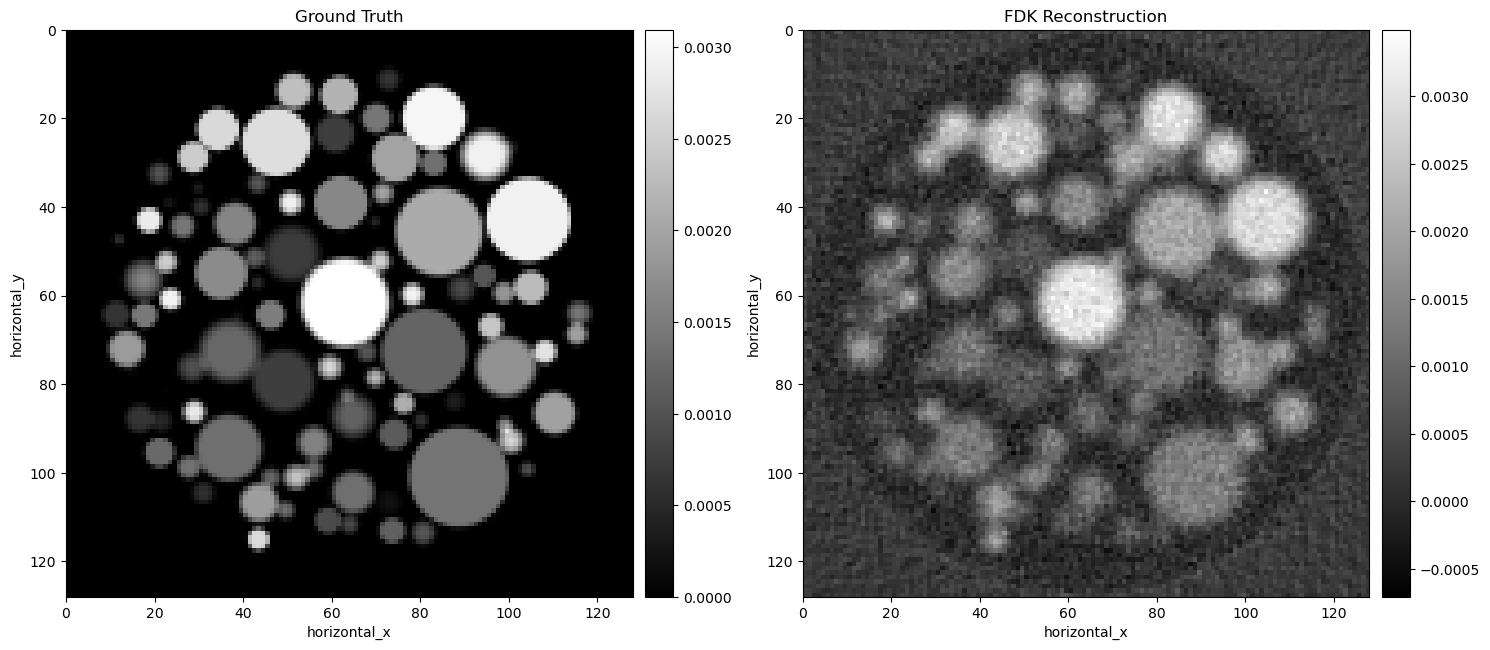

In [9]:
recon_FDK = FDK(noisy_absorption, image_geometry=ig).run()

show2D([ground_truth, recon_FDK], title=['Ground Truth',
       'FDK Reconstruction'], origin='upper', num_cols=2);

## FISTA + TV Recon 

As a baseline we try a TV reconstruction with a non-negativity constraint, using the FISTA algorithm, minimising the objective 

$$ \arg \min_x \|ABx-y\|_2^2  + \alpha g(x)$$ 

 where $B$ is the blurring operator, $A$ the tomographic projection operator, $ y$ the noisy measured data and $g$ is the TV regulariser with regularisation paramater $\alpha$. 

 We try a few regularisation parameters and visualise the results: 

In [10]:
list_alpha=[1, 10, 100, 200]
list_solutions_TV = []
for alpha in [1, 10, 100, 200]:
    F = LeastSquares(A=forward, b=noisy_absorption)
    G = alpha*TotalVariation(lower=0)

    algo_tv = FISTA(initial=ig.allocate(0), f=F, g=G,
                    update_objective_interval=10)
    algo_tv.run(250)
    list_solutions_TV.append(algo_tv.solution)


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
    ^^^^^^^^^^^
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/bgb3

  0%|          | 0/250 [00:00<?, ?it/s]

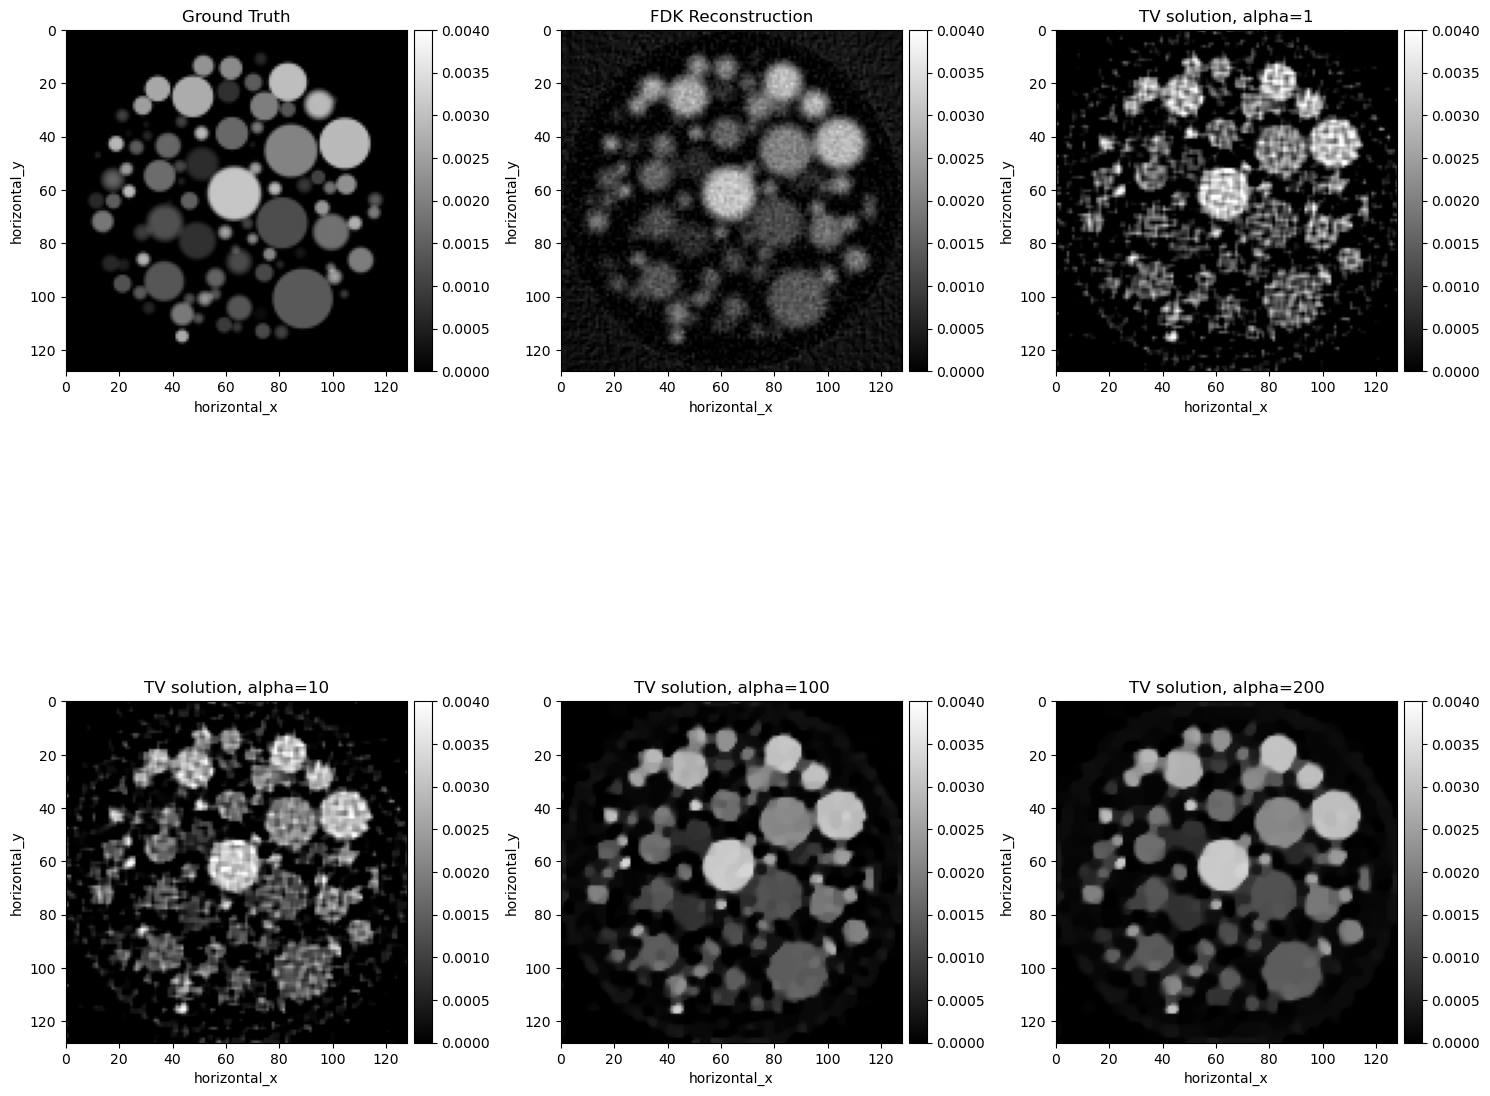

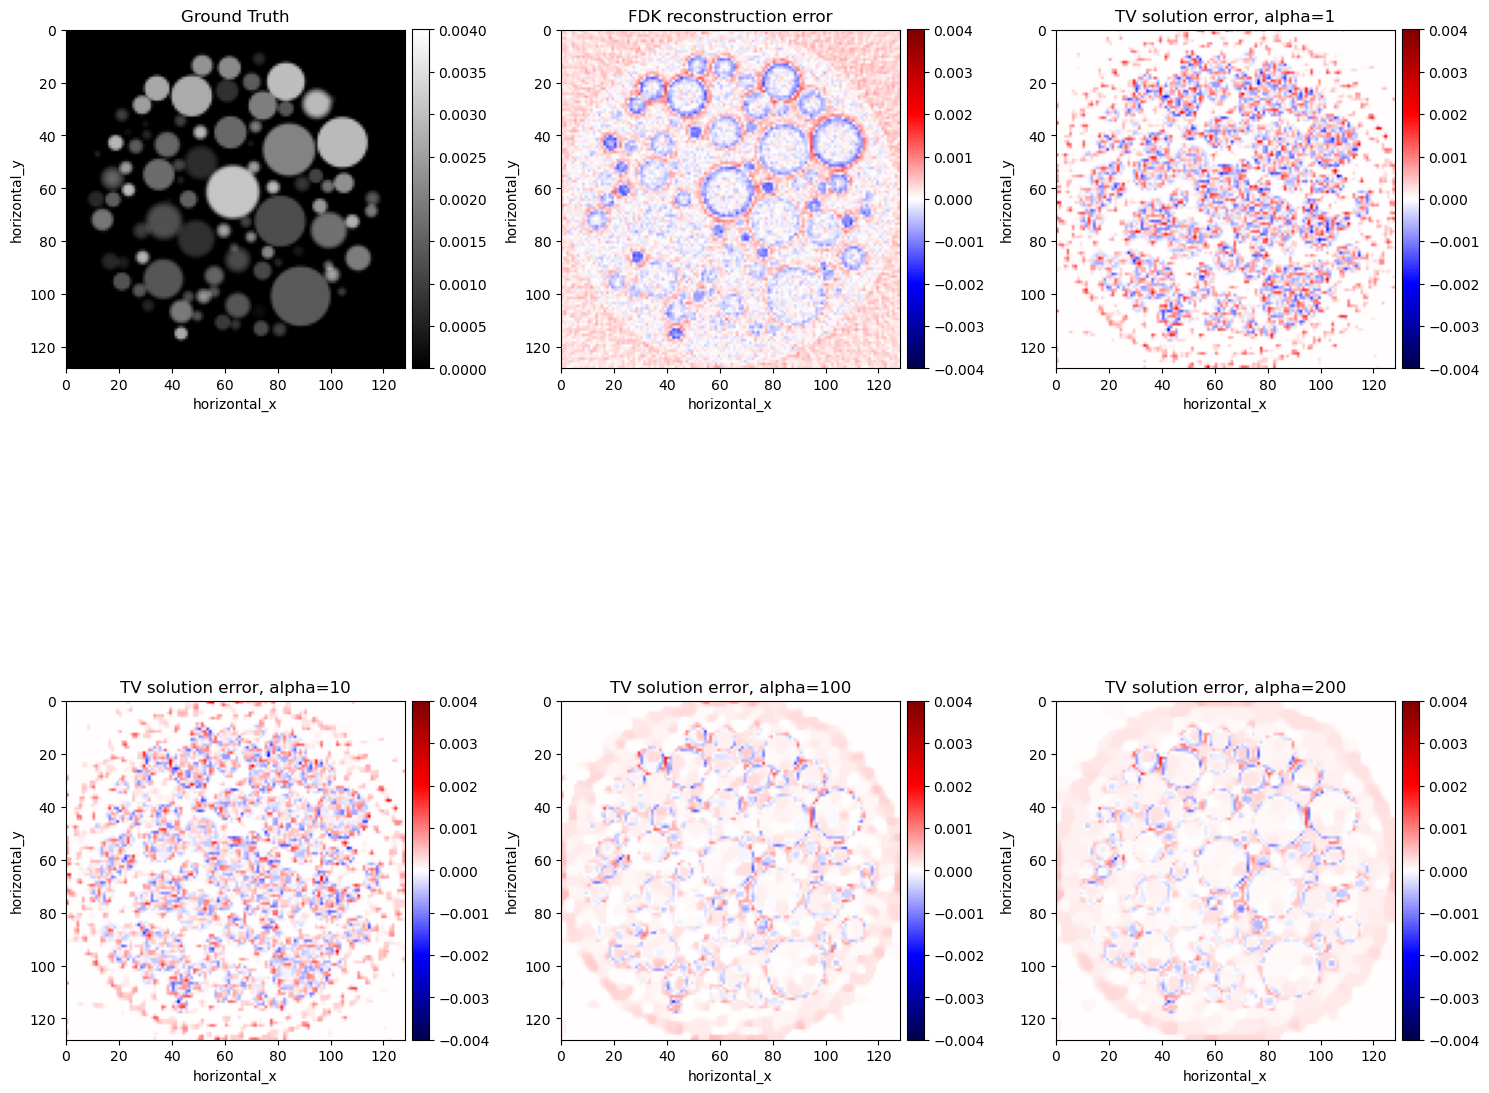

In [11]:
show2D([ground_truth, recon_FDK, list_solutions_TV[0], list_solutions_TV[1], list_solutions_TV[2], list_solutions_TV[3]], title=['Ground Truth', 'FDK Reconstruction',
           'TV solution, alpha={}'.format(list_alpha[0]), 'TV solution, alpha={}'.format(list_alpha[1]), 'TV solution, alpha={}'.format(list_alpha[2]), 'TV solution, alpha={}'.format(list_alpha[3])], origin='upper', num_cols=3, fix_range=(0, 0.004));
show2D([ground_truth, recon_FDK - ground_truth, list_solutions_TV[0] - ground_truth, list_solutions_TV[1] - ground_truth, list_solutions_TV[2] - ground_truth, list_solutions_TV[3] - ground_truth], title=['Ground Truth', 'FDK reconstruction error',
           'TV solution error, alpha={}'.format(list_alpha[0]), 'TV solution error, alpha={}'.format(list_alpha[1]), 'TV solution error, alpha={}'.format(list_alpha[2]) , 'TV solution error, alpha={}'.format(list_alpha[3])], origin='upper', num_cols=3, fix_range=[(0, 0.004), (-0.004, 0.004), (-0.004, 0.004), (-0.004, 0.004), (-0.004, 0.004), (-0.004, 0.004)], cmap=['gray', 'seismic', 'seismic', 'seismic', 'seismic', 'seismic']);

We see that the larger values of regularisation parameter, $alpha$, give a smaller error compared with the ground truth image. However, they give quite blocky/cartoon-like images, as expected for TV regularisation. There are errors between the spheres, where they appear still joined together. 


## Directional Total Variation 

The directional total variation regulariser uses a reference image. The idea is that the $\textrm{dTV}(x)$ function is smaller when the gradients of $x$ are more aligned with those of the reference image, reaching its minimum when all gradients are perfectly parallel. This regulariser encourages the gradient of the reconstructed image to be equal to or parallel to the gradient of the reference image. The CCPi regularisation toolkit implementation also allows us to add a non-negativity constraint. 

### Mathematical description (can be skipped if wished)

First, define the normalised gradient, $\zeta$ of the reference image, $\nu$ as $$\zeta = -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}}.$$
Here, $\eta$ is a scalar smoothing parameter to ensure the denominator is always non-zero and is chosen so that  $0<\eta<<\|\nabla\nu\|$.

For a 2D image, $\nu \in \mathbb{R}^{n\times m}$, the gradient is calculated in the horizontal and vertical directions and thus the gradient $\nabla \nu \in \mathbb{R}^{n\times m \times 2}$. We then  define  $|\nabla\nu|$ to be defined pixel wise as $|\nabla\nu|_{i,j}^2=\nabla\nu_{i,j,0}^2 + \nabla\nu_{i,j,1}^2 $. The addition, square root and division is done pixel wise. 

For each point in the image space we now have a direction of normalised length, described by a horizontal and vertical component, in the same direction as the gradient of the reference image at that point. 

We now define weights $D$ to be $$D=I-\zeta \zeta^T.$$

This is chosen such that, when applied to the gradient of an image $x$, it is small if the gradients of $x$ and $\nu$ align.

As a simple example, consider that the gradient of the reconstructed image, $x$,  and the reference image, $\nu$,  are perpendicular so that $\nabla x^T\nabla \nu=0$. We then have that

$$D\nabla x = (I-\zeta \zeta^T)\nabla x= \nabla x - \dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla x =\nabla x. $$
Thus, encouraging $D\nabla x$ to be small, means encouraging gradients of $x$ perpendicular to the gradients of the reference image to be small. 

For a second example, consider that $\nabla x= \gamma \nabla \nu$ i.e. the gradients of $x$ are a multiple of the gradients of the reference image,  then

 $$D\nabla x = \gamma D\nabla \nu= \gamma (I-\zeta \zeta^T)\nabla \nu= \gamma \left(\nabla \nu -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla \nu \right)=\gamma \nabla \nu \left(1-|\zeta|^2\right) = \nabla x \left(1-|\zeta|^2 \right)$$
So, in the case where the gradients of $x$ are a multiple of the gradients of the reference image, and that  $|\zeta|^2$ is close to but less than 1 (recall that $0<\eta<<\|\nabla\nu\|$) and  we have that $D\nabla x $ is a small constant multiplied by $\nabla x$. This weighting means that gradients parallel to the reference image are penalised much less than gradients perpendicular to the reference image. 


We thus define the directional total variation regulariser 

$$g(x) =\textrm{dTV}(x):= \sum_i||\left(D\nabla x\right)_i||_2$$

 where the sum is over the entries, $i$, of the object $D\nabla x$. Again, in the two dimensional case this is the sum of the norms of the gradients in the horizontal and vertical directions. 











### Create reference image 

To use this regulariser we need a reference image. In the next cell we create a reference image for our reconstruction. From the original spheres image we take just some of the spheres and change the values, compared to the original image. This is to mimic a reference image being taken using a different imaging modality, that would give different intensity values, and might not be able to see all the elements of an image. 

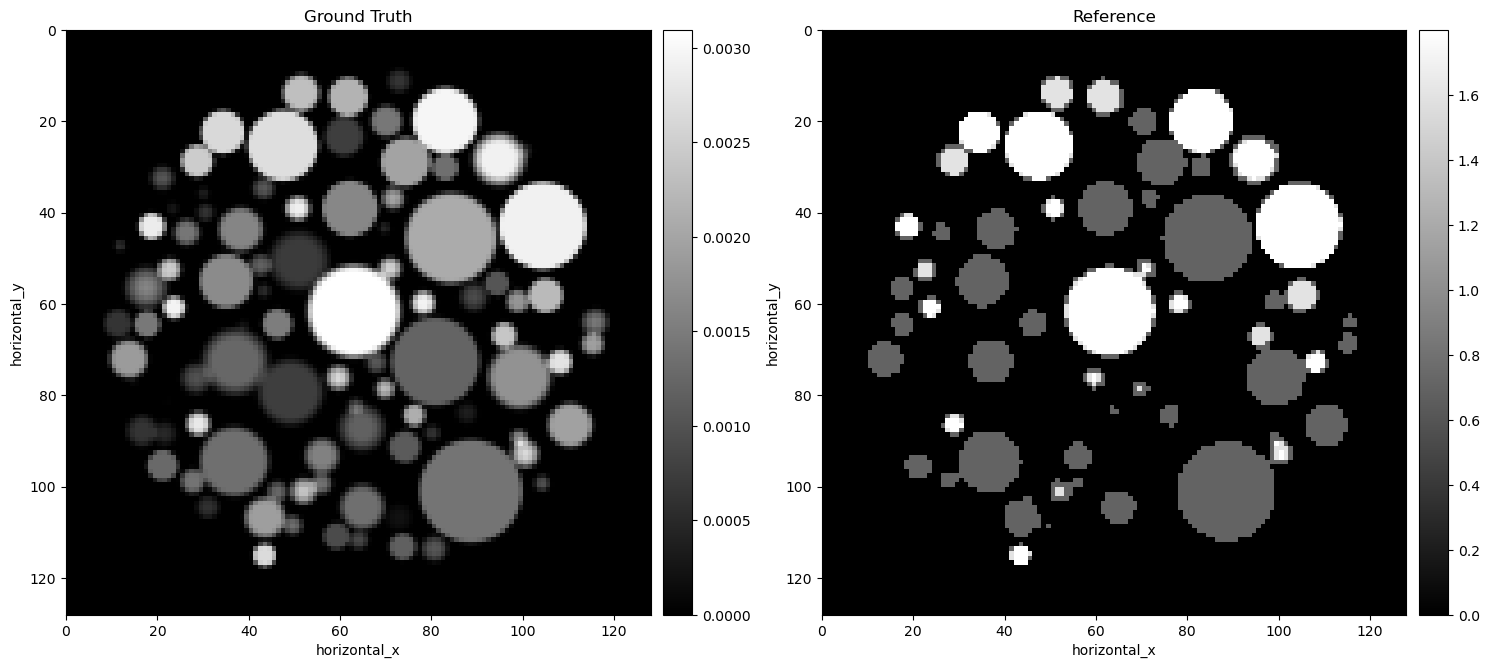

In [12]:
# %% create masks
top = ig.allocate(0)
bottom = ig.allocate(0)
middle = ig.allocate(0)

top.fill(
    np.asarray(ground_truth.array > 0.8 * ground_truth.max(),
               dtype=np.float32)
)
bottom.fill(
    np.asarray(np.invert(ground_truth.array < 0.4 * ground_truth.max()),
               dtype=np.float32)
)
middle.fill(
    np.asarray(np.invert(ground_truth.array < 0.7 * ground_truth.max()),
               dtype=np.float32)
)


reference = top*0.2+bottom*0.7 + middle*0.9
show2D([ground_truth, reference], title=[
       'Ground Truth', 'Reference'], origin='upper', num_cols=2);

### Results using dTV
We can now compare the dTV results for a number of values of the regularisation parameter,  $\alpha$. 

In [13]:
list_alpha=[1, 10, 100, 1000]
list_solutions_dTV = []
for alpha in list_alpha:
    eta = 0.01
    F = LeastSquares(A=forward, b=noisy_absorption)
    G = FGP_dTV(reference=reference, alpha=alpha, eta=eta, nonnegativity=True)

    algo_dtv = FISTA(initial=ig.allocate(0), f=F, g=G,
                     update_objective_interval=10)
    algo_dtv.run(250)
    list_solutions_dTV.append(algo_dtv.solution)


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f5ed78fd1c0>
Traceback (most recent call last):
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/notebook.py", line 282, in close
    self.disp(bar_style='success', check_delay=False)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/tqdm/notebook.py", line 157, in display
    pbar.value = self.n
    ^^^^^^^^^^
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/home/bgb37495/miniconda3/envs/cil_test_demos/lib/python3.12/site-packages/traitlets/t

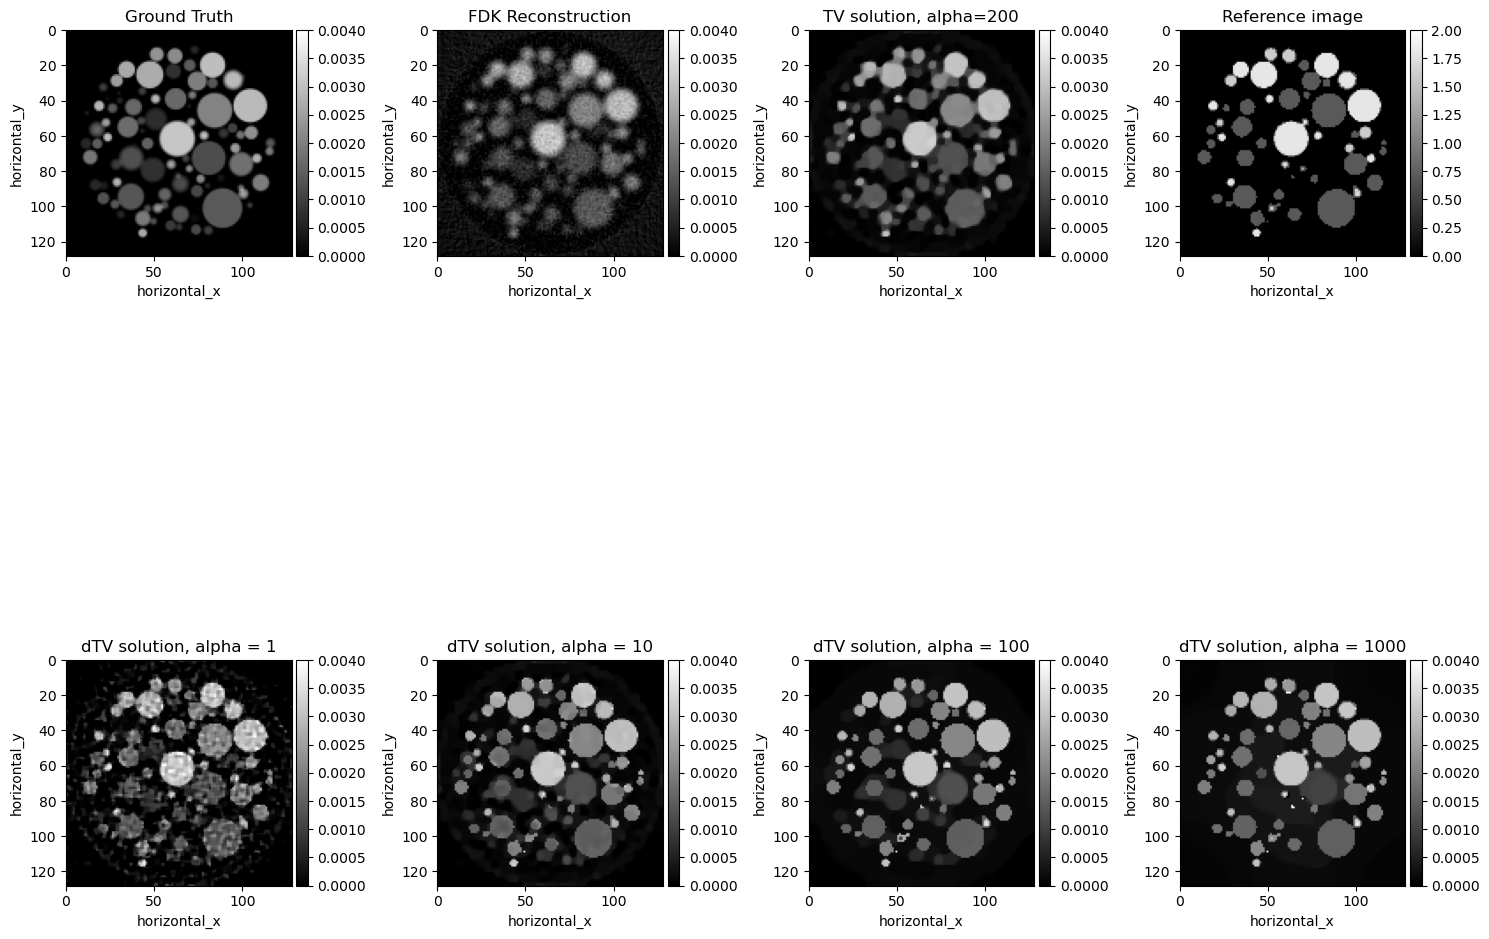

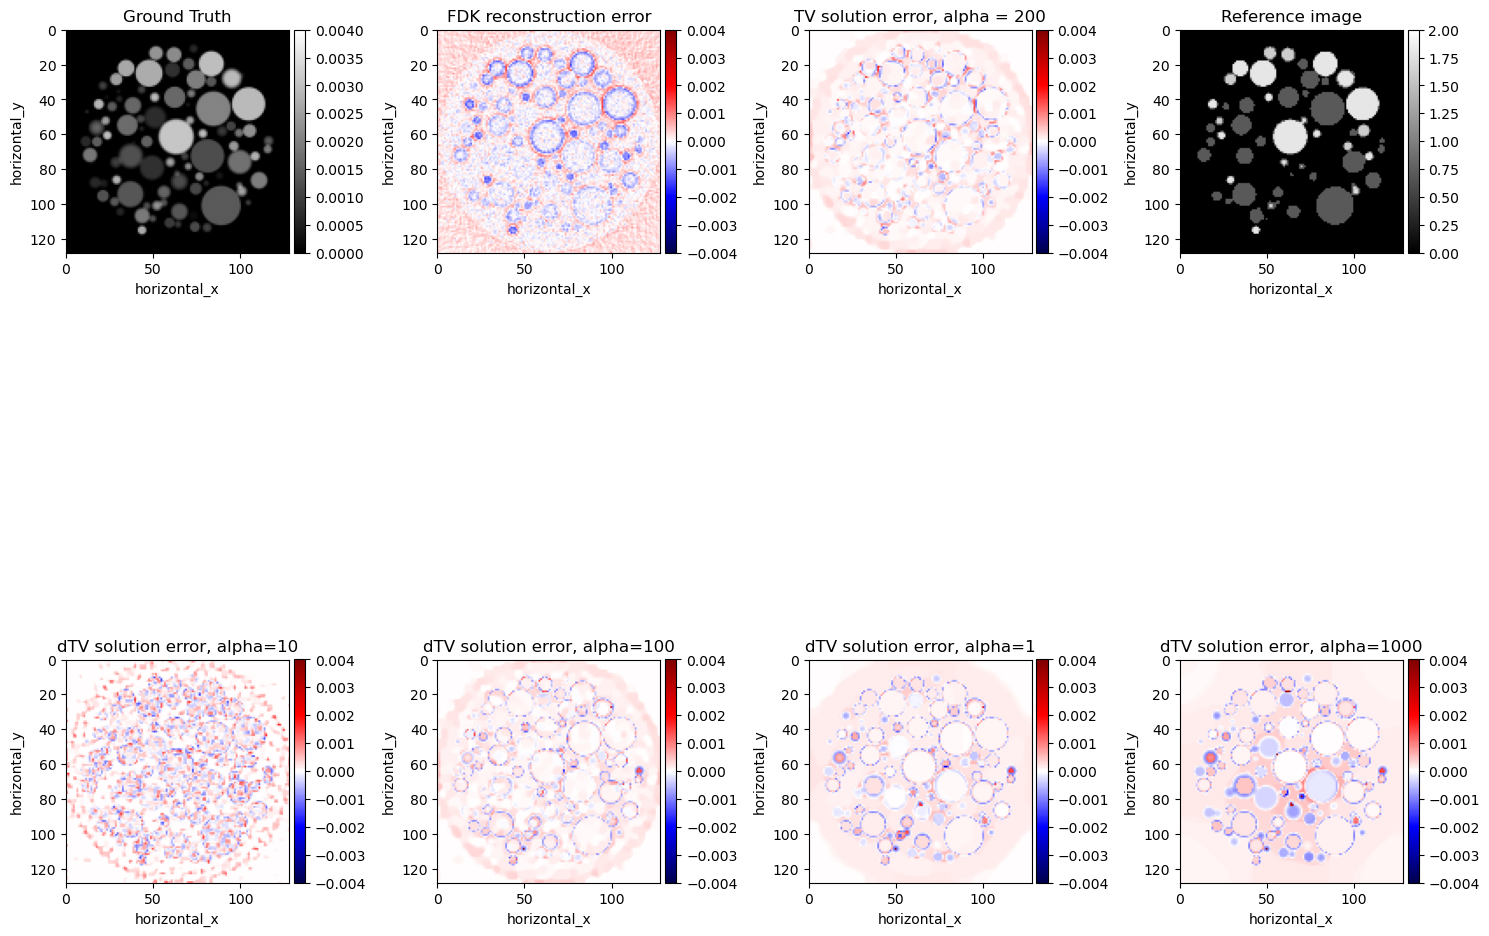

In [14]:
show2D([ground_truth, recon_FDK, list_solutions_TV[3], reference,  list_solutions_dTV[0],list_solutions_dTV[1],list_solutions_dTV[2],list_solutions_dTV[3],], title=['Ground Truth', 'FDK Reconstruction', 'TV solution, alpha=200',
       'Reference image',  'dTV solution, alpha = {}'.format(list_alpha[0]), 'dTV solution, alpha = {}'.format(list_alpha[1]), 'dTV solution, alpha = {}'.format(list_alpha[2]), 'dTV solution, alpha = {}'.format(list_alpha[3])], origin='upper', num_cols=4, fix_range=[(0, 0.004), (0, 0.004), (0, 0.004), (0, 2), (0, 0.004), (0, 0.004), (0, 0.004), (0, 0.004)]);
show2D([ground_truth, recon_FDK - ground_truth, list_solutions_TV[3] - ground_truth, reference,  list_solutions_dTV[0] - ground_truth,  list_solutions_dTV[1] - ground_truth,  list_solutions_dTV[2] - ground_truth,  list_solutions_dTV[3] - ground_truth], title=['Ground Truth', 'FDK reconstruction error', 'TV solution error, alpha = 200', 'Reference image',
       'dTV solution error, alpha={}'.format(list_alpha[1]), 'dTV solution error, alpha={}'.format(list_alpha[2]), 'dTV solution error, alpha={}'.format(list_alpha[0]), 'dTV solution error, alpha={}'.format(list_alpha[3])], origin='upper', num_cols=4, fix_range=[(0, 0.004), (-0.004, 0.004), (-0.004, 0.004), (0, 2), (-0.004, 0.004), (-0.004, 0.004), (-0.004, 0.004), (-0.004, 0.004)], cmap=['gray', 'seismic', 'seismic', 'gray', 'seismic', 'seismic', 'seismic', 'seismic']);


Too small a value of alpha for dTV reconstruction and the solution is noisy and we get some odd artifacts because of the blurring operator. For intermediate values of alpha, the dTV reconstruction gives sharp edges around the spheres in the reference image and blurrier reconstructions of the other spheres. For too large values of alpha, the dTV solution fails to reconstruct the spheres not in the reference image. In this case, too much weight has been given to the reference image and not enough to the data. This is a risk of adding information to the problem, in this way. 

### Exercise 

The $\eta$ value controls the weighting $D$ that is applied to the gradient. Play around with the $\eta$ value in the above code and see what you observe. A smaller value of $\eta$ will weight the gradients in the reference image more and a larger value of $\eta$ will focus more on gradients across the image.

### Comparisons 

We can now compare all of our results so far

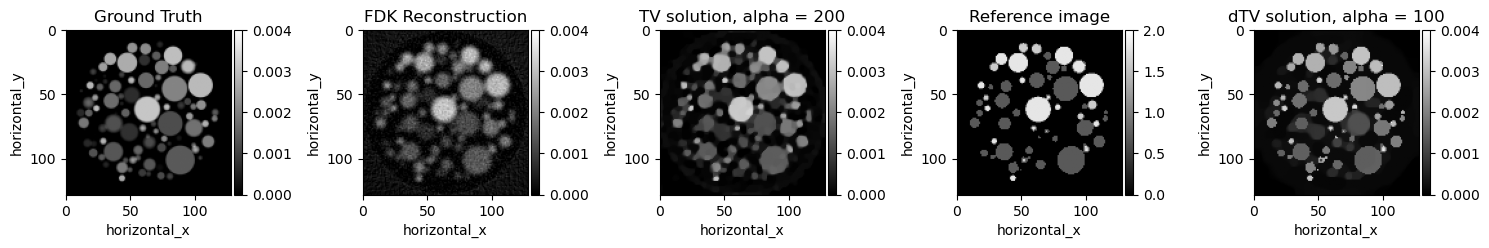

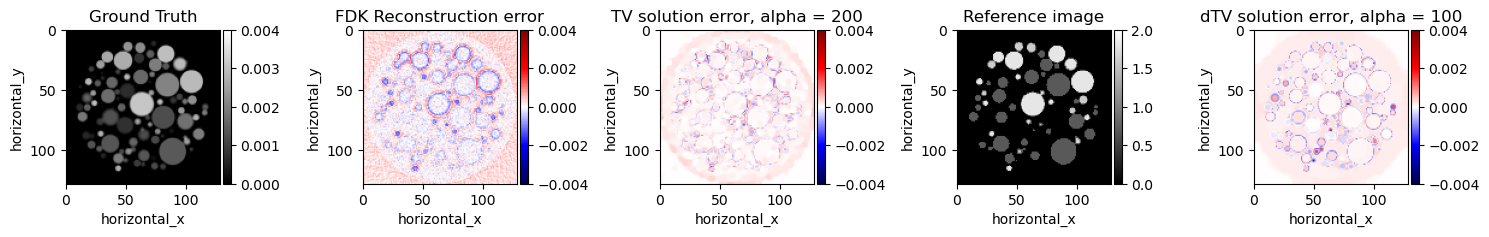

In [15]:

show2D([ground_truth, recon_FDK, algo_tv.solution, reference,  list_solutions_dTV[2]], title=['Ground Truth', 'FDK Reconstruction', 'TV solution, alpha = 200',
       'Reference image',  'dTV solution, alpha = {}'.format(list_alpha[2])], origin='upper', num_cols=5, fix_range=[(0, 0.004), (0, 0.004), (0, 0.004), (0, 2), (0, 0.004)]);
show2D([ground_truth, recon_FDK-ground_truth, algo_tv.solution-ground_truth, reference, list_solutions_dTV[2]-ground_truth], title=['Ground Truth', 'FDK Reconstruction error', 'TV solution error, alpha = 200',
       'Reference image',  'dTV solution error, alpha = {}'.format(list_alpha[2])], origin='upper', cmap=['gray', 'seismic', 'seismic', 'gray', 'seismic'], num_cols=5, fix_range=[(0, 0.004), (-0.004, 0.004), (-0.004, 0.004), (0, 2), (-0.004, 0.004)]);

## Directional TV regularisation, written in CIL (optional)

In this section we consider using the reference image to improve the FDK reconstructed image. We treat this as just a denoising problem and ignore the tomography forward operator. We try and avoid using the regularisation toolkit and instead write everything using CIL operators and functions. 

You might want to look at this section if:
- You are interested in inverse problems where the forward operator is expensive or difficult to calculate - this section looks at denoising a "rough" reconstruction. 
- You are interested in building complex objective functions using CIL.  



Recall the FDK reconstruction from above: 


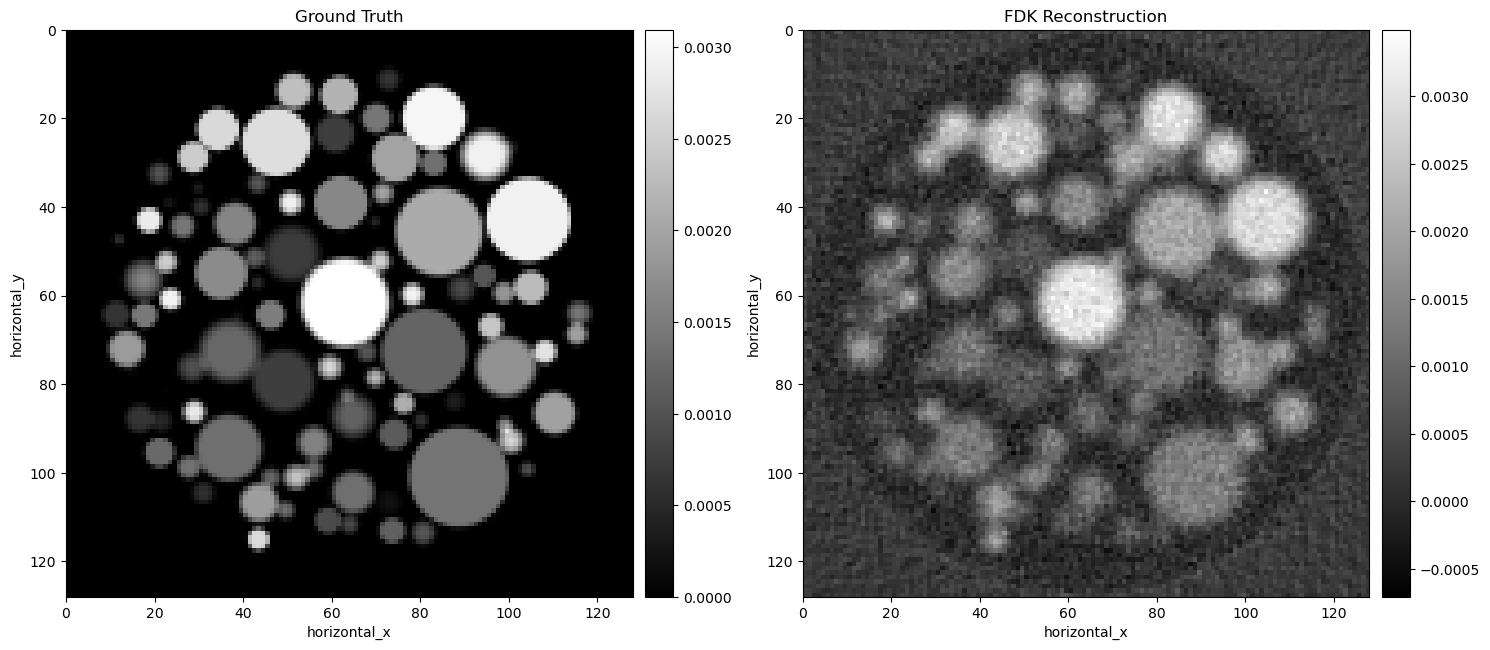

In [16]:

show2D([ground_truth, recon_FDK], title=['Ground Truth',
       'FDK Reconstruction'], origin='upper', num_cols=2);

 In this case, we choose to denoise the FDK reconstruction using the directional TV regularisation term, i.e. solving the problem

$$ \arg \min_x \|x-x_{FDK}\|_2^2  + \alpha \textrm{dTV}(x) .$$ 

We could use dTV from the regularisation toolkit as above but instead take the opportunity to demonstrate using the BlockOperators in CIL to build up challenging objective functions to minimise.  



We use PDHG, which solves problems of the form 
$$
\min_{x\in\mathbb{X}} \mathcal{F}(K x) + \mathcal{G}(x)
\tag{PDHG form}
$$

where $F$ and $G$ need to have a calculable proximal and proximal conjugate,  respectively.  We choose $G$ to be the `L2NormSquared` function, $\min_x \|x-x_{FDK}\|_2^2 $ which has a calculable proximal conjugate in CIL.   


In [17]:
# fidelity term
g = L2NormSquared(b=recon_FDK)

This leaves the term $\mathcal{F}(K x) $ to be $\alpha \textrm{dTV}(x) $. In the next few blocks, we will set this up. 

First define a discrete gradient operator, using BlockOperators, that computes finite differences in the vertical and horizontal directions:

$$ \nabla(x) = 
\begin{bmatrix}
   \nabla_v\\
   \nabla_h\\
\end{bmatrix}
x =
\begin{bmatrix}
    \nabla_vx\\
    \nabla_hx\\
\end{bmatrix} $$



In [18]:
DX = FiniteDifferenceOperator(ig, direction=0)
DY = FiniteDifferenceOperator(ig, direction=1)

Grad = BlockOperator(DX, DY)



Using this, we can define the normalised gradient $\zeta = -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}}$. This is a BlockDataContainer. 



In [19]:

grad_ref = Grad.direct(reference)
#setting the constant eta 
eta = 1e-2* grad_ref.norm()
denom = np.sqrt(eta**2 + grad_ref.pnorm(2)**2)
zeta = grad_ref/denom

We can visualise $\zeta$ to see the vertical and horizontal gradients of the reference image. We first use `show2D` to visualise the vertical and horizontal components and then use a quiver plot to combine the two. 

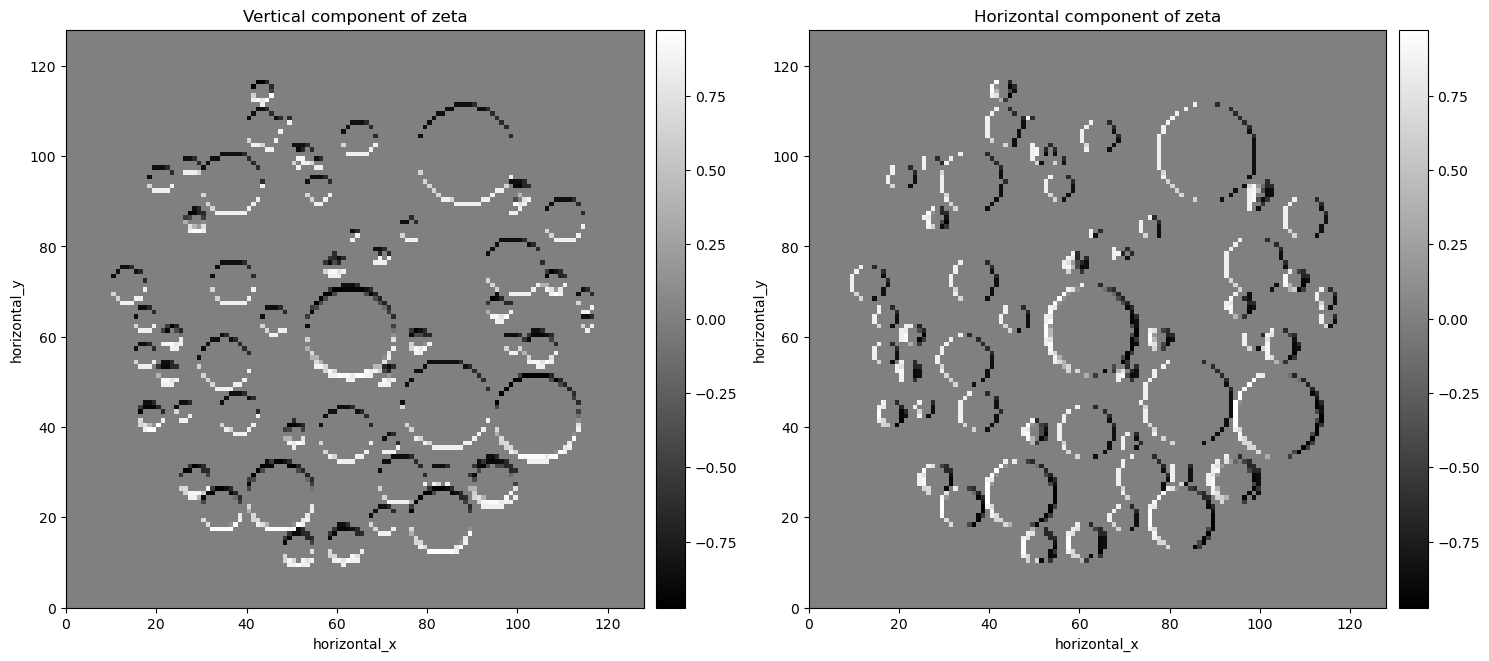

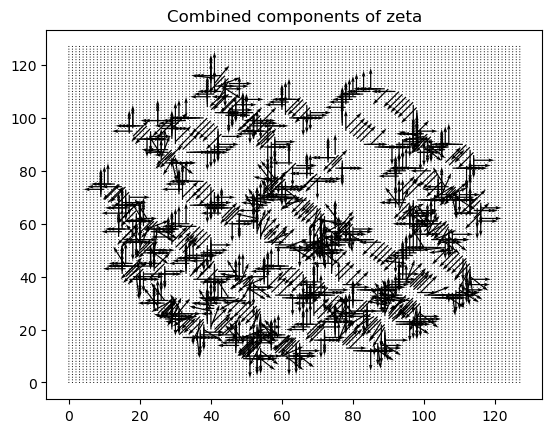

In [20]:
show2D(zeta, title=['Vertical component of zeta', 'Horizontal component of zeta' ]);
plt.plot
x = np.arange(0, 128)
y = np.arange(0, 128)
 
X, Y = np.meshgrid(x, y)
plt.quiver(X,Y, zeta[0].as_array(), zeta[1].as_array())
plt.title("Combined components of zeta")
plt.show()

Recall that $$D=I-\zeta \zeta^T$$ and that we are looking to compute $D\nabla x$. Let's look at the operator $D\nabla$:

$$ D\nabla = (I-\zeta \zeta^T)\nabla = \left(I-\begin{bmatrix}
   \zeta_0\\
   \zeta_1\\
\end{bmatrix} \begin{bmatrix}
   \zeta_0 \ \ 
   \zeta_1\\
\end{bmatrix}  \right)\begin{bmatrix}
   \nabla_v\\
   \nabla_h\\
\end{bmatrix}$$

where $\zeta_0$ and $\zeta_1$ are the normalised gradient of $\nu$ in the horizontal and vertical directions, the two elements of the $\zeta$ BlockOperator we defined above. 

This can be simplified to be 
$$ D\nabla = \begin{bmatrix}
   \nabla_v- \left(\zeta_0^2\nabla_v + \zeta_0\zeta_1\nabla_h\right)\\
   \nabla_h - \left(\zeta_1\zeta_0\nabla_v + \zeta_1^2\nabla_h\right)\\
\end{bmatrix}. $$

Looking at the first entry in the BlockOperator, $\nabla_v- \left(\zeta_0^2\nabla_v + \zeta_0\zeta_1\nabla_h\right)$, we do a pointwise multiplication for $\zeta_0^2\nabla_v$ and $\zeta_0\zeta_1\nabla_h$ using a `DiagonalOperator` and a `CompositionOperator`:


In [21]:
A1 = DX - CompositionOperator(DiagonalOperator(zeta[0]**2), DX)- CompositionOperator(DiagonalOperator(zeta[0]*zeta[1]), DY) 



We can then do the same for the second entry and create a block operator.

In [22]:

A2 = DY - CompositionOperator(DiagonalOperator(zeta[1]*zeta[0]), DX) - CompositionOperator(DiagonalOperator(zeta[1]**2), DY) 


operator = BlockOperator(A1, A2)



We then choose $F$ to be $\alpha$ multiplied by the  `MixedL21Norm`: $\| X \|_{2,1} = \sum_{i=1}^{m} \| X_i \|_2$. This will do the two norm and the sum to calculate the dTV regulariser. 

Note: We try with the regularisation parameter $\alpha=0.02$. This is different to the optimal parameter above because we have a different forward model and the CCPi Regularisation toolikt and CIL dTV implementation may have different scaling. 


In [23]:
#Regularisation parameter 
alpha = 0.02
f = alpha * MixedL21Norm()


We can now run the PDHG algorithm to minimise the objective $\mathcal{F}(K x) + \mathcal{G}(x)$. 

Note: our choice of $G$ being strongly convex means we can use primal acceleration in PDHG. 

  0%|          | 0/500 [00:00<?, ?it/s]

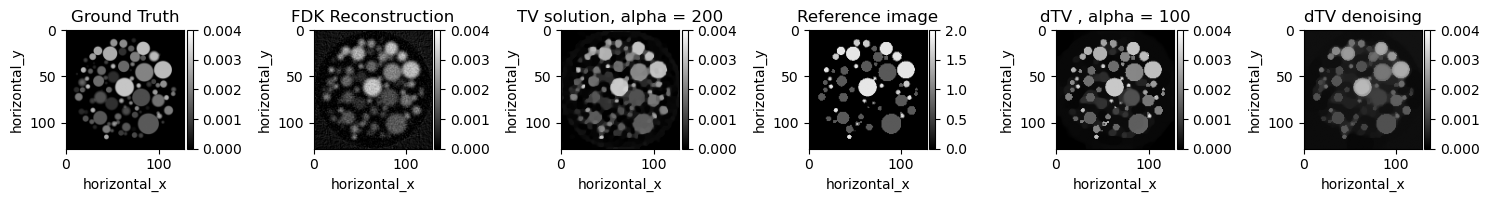

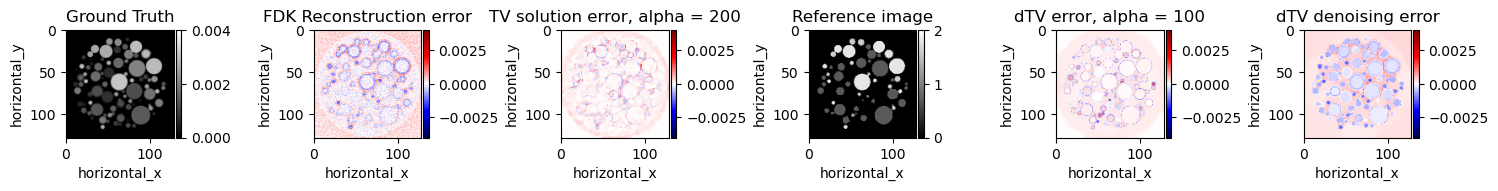

In [24]:
pdhg = PDHG(f=f, g=g, operator=operator,
            update_objective_interval=100, gamma_g=1.) # use primal acceleration, g being strongly convex
pdhg.run(500)



show2D([ground_truth, recon_FDK, algo_tv.solution, reference, list_solutions_dTV[2],  pdhg.solution], title=['Ground Truth', 'FDK Reconstruction', 'TV solution, alpha = 200',
       'Reference image', 'dTV , alpha = {}'.format(list_alpha[2]),  'dTV denoising'], origin='upper', num_cols=6, fix_range=[(0, 0.004), (0, 0.004), (0, 0.004), (0, 2), (0, 0.004), (0, 0.004)]);
show2D([ground_truth, recon_FDK-ground_truth, algo_tv.solution-ground_truth, reference, list_solutions_dTV[2]-ground_truth,  pdhg.solution-ground_truth, ], title=['Ground Truth', 'FDK Reconstruction error', 'TV solution error, alpha = 200',
       'Reference image', 'dTV error, alpha = {}'.format(list_alpha[2]), 'dTV denoising error'], origin='upper', cmap=['gray', 'seismic', 'seismic', 'gray','seismic', 'seismic'], num_cols=6, fix_range=[(0, 0.004), (-0.004, 0.004), (-0.004, 0.004), (0, 2), (-0.004, 0.004), (-0.004, 0.004)]);

Compared to the FDK reconstruction, the dTV denoising solution has sharper edges and reduced noise. Recall that this dTV reconstruction was set-up to denoise the FDK reconstruction and was unaware of the tomography set-up or the tomographic data. Compared to the TV solution, which utilised this knowledge, the errors plot shows higher errors, especially in the background and in the intensity values of some of the spheres. The best result remains the dTV solution that was aware of the tomography forward problem. 

## Further work
This notebook is not quite complete. It would be good to use a CIL dTV implementation for the full forward problem, including the tomographic operators and data. However, CIL currently can't take the proximal of an operator composed with a function so there is no proximal defined for the CIL LeastSquares function (https://github.com/TomographicImaging/CIL/issues/1561). This means we cannot use a CIL LeastSquares function as the function $G$ in PDHG. 